In [174]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
from scipy.ndimage import gaussian_filter
from scipy.signal import welch
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from config import *
from functions import *
from sim import *
from read_ramses import *


In [177]:
# choose simulation
sim_round = 9
sim_name = "fiducial"
sim_dir = move_to_sim_dir(sim_round, sim_name)
sim_latex = sim_name_to_latex[sim_name]
print()

dump = get_dump(aexp=0.1)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.aexp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.

Dump: 52
a_exp: 0.1
Maximum AMR level: 13


In [178]:
data = SimpleNamespace(**np.load('starcat/data.npz'))
data.SFR = data.starmass_hist1d / np.diff(data.time1d)[0]

aexp_list = np.linspace(1e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list, fill_value='extrapolate')


In [179]:
norm_resp_func = lambda resp_func: resp_func / np.sum(resp_func)
data_resp_func = SimpleNamespace(**np.load(os.path.join(analysis_dir, 'resp_func.npz')))

resp_func_list = ['Halpha', 'OIII', 'f200w', 'f277w']
for resp_func_name in resp_func_list:
    
    # interpolate response function to time array
    resp_func_interp = interp1d(data_resp_func.time, getattr(data_resp_func, resp_func_name), fill_value='extrapolate')
    resp_func = norm_resp_func(resp_func_interp(data.time1d))
    
    # convolve response function with SFR
    SFR_conv = np.zeros_like(data.SFR)
    for i in range(SFR_conv.size):
        SFR_conv[i] = np.sum(data.SFR[:i] * resp_func[:i][::-1])
        
    setattr(data, 'SFR_%s' % resp_func_name, SFR_conv)


### SFH

Text(0.5, 0, '$a_{\\rm exp}$')

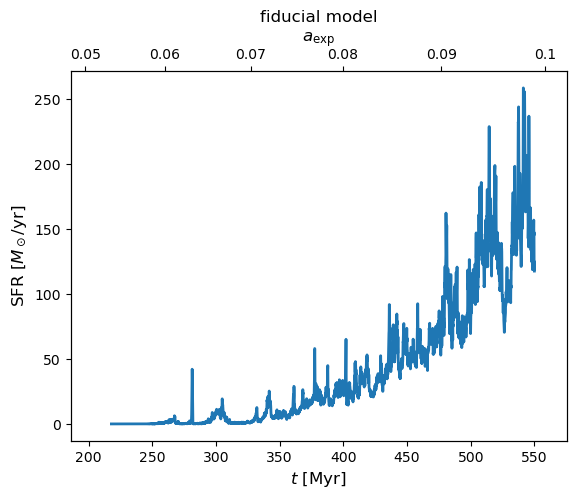

In [181]:
# define aexp ticks
aexp_min = 0.048
aexp_max = 0.102
tick_aexp = np.arange(0.05, 0.1 + 0.01, 0.01)

# create axes
ax1 = plt.gca()
ax2 = ax1.twiny()

# plot SFR
cond = (data.SFR > 0)
ax1.plot(data.time1d[cond] / const.Myr, data.SFR[cond] / (const.M_sol / const.yr), lw=2, color='C0')

# set up primary axis
ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$]", fontsize=12)
ax1.set_xlabel(r"$t$ [Myr]", fontsize=12)
ax1.set_title(sim_latex)

# set up seconary axis
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)


Saved figure as 'SFR_conv-022220241630.png'


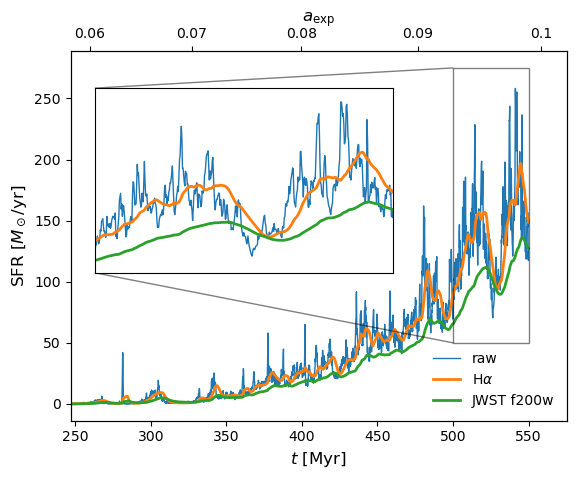

In [182]:
# define aexp ticks
aexp_min = 0.058
aexp_max = 0.102
tick_aexp = np.arange(0.06, 0.1 + 0.01, 0.01)

# list response functions
resp_func_list = [(r'H$\alpha$', 'Halpha'), ('JWST f200w', 'f200w')]

# create axes
fig = plt.figure()
ax1 = plt.gca()
ax2 = ax1.twiny()
ax3 = ax1.inset_axes([0.05, 0.4, 0.6, 0.5], xlim=(500, 550), ylim=(50, 275), xticks=[], yticks=[])

# plot raw SFR
ax1.plot(data.time1d / const.Myr, data.SFR / (const.M_sol / const.yr), label='raw', lw=1)
ax3.plot(data.time1d / const.Myr, data.SFR / (const.M_sol / const.yr), lw=1)

for resp_func_label, resp_func_name in resp_func_list:

    # plot convolved SFR
    SFR_conv = getattr(data, 'SFR_%s' % resp_func_name)
    ax1.plot(data.time1d / const.Myr, SFR_conv / (const.M_sol / const.yr), label=resp_func_label, lw=2)
    ax3.plot(data.time1d / const.Myr, SFR_conv / (const.M_sol / const.yr), lw=2)

# set up inset axis
ax1.indicate_inset_zoom(ax3, edgecolor="black")
    
# set up primary axis
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$]", fontsize=12)
ax1.set_xlabel(r"$t$ [Myr]", fontsize=12)
ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.legend(loc=4, frameon=False)

# set up seconary axis
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)

save_fig('SFR_conv')


/tmp/ipykernel_136036/3151846509.py:8: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_ds)
/tmp/ipykernel_136036/3151846509.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2)


Text(0.5, 1.0, 'fiducial model')

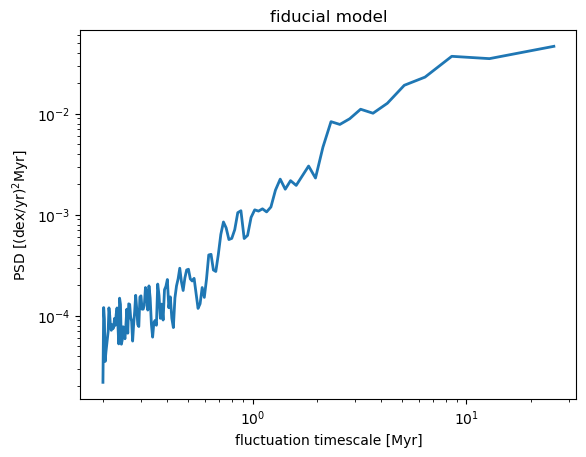

In [163]:
norm_resp_func = lambda resp_func: resp_func / np.sum(resp_func)
resp_func_list = [(r'H$\alpha$', data_resp_func.Halpha), ('JWST f200w', data_resp_func.f200w)]

fac_ds = 1
time1d_ds, SFR_ds = downsample_hist(data.time1d, data.SFR, fac_ds=fac_ds)

cond = (time1d_ds > 350 * const.Myr) * (SFR_ds > 0)
log_SFR = np.log10(SFR_ds)
freq, psd = welch(log_SFR[cond], 1/(time1d_ds[1] - time1d_ds[0]), detrend='linear')

plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex/yr)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(sim_latex)

# save_fig("SFR-dxmin")


/tmp/ipykernel_136036/593483211.py:5: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_ds)
/tmp/ipykernel_136036/593483211.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label='raw')
/tmp/ipykernel_136036/593483211.py:12: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_conv)
/tmp/ipykernel_136036/593483211.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=resp_func_label)


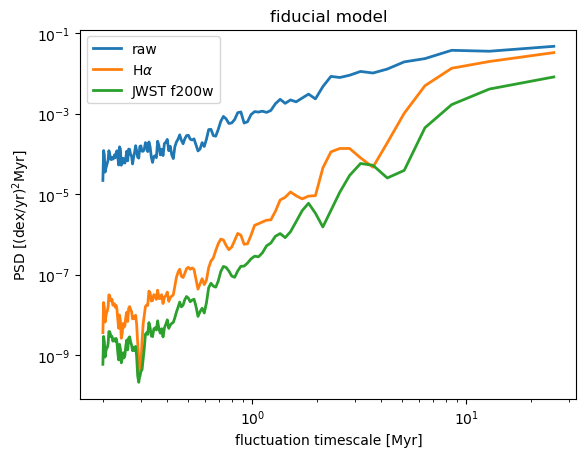

In [164]:
# list response functions
resp_func_list = [(r'H$\alpha$', 'Halpha'), ('JWST f200w', 'f200w')]

cond = (data.time1d > 350 * const.Myr)
log_SFR = np.log10(SFR_ds)
freq, psd = welch(log_SFR[cond], 1/(time1d_ds[1] - time1d_ds[0]), detrend='linear')
plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label='raw')

for resp_func_label, resp_func_name in resp_func_list:

    SFR_conv = getattr(data, 'SFR_%s' % resp_func_name)
    log_SFR = np.log10(SFR_conv)
    freq, psd = welch(log_SFR[cond], 1/(data.time1d[1] - data.time1d[0]), detrend='linear')
    plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=resp_func_label)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex/yr)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(sim_latex)
plt.legend()

#save_fig('SFRpsd_conv')


Saved figure as 'SFRmass_conv-022220241323.png'


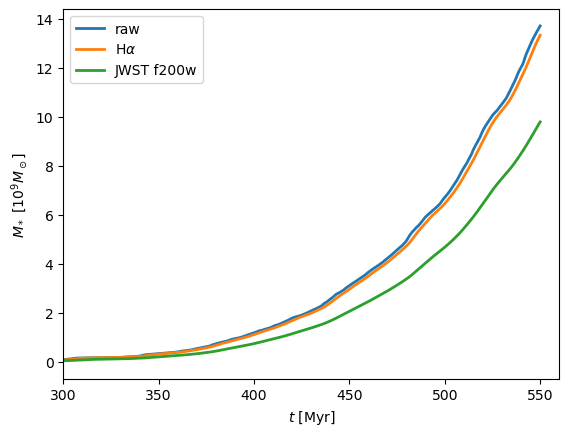

In [165]:
# list response functions
resp_func_list = [(r'H$\alpha$', 'Halpha'), ('JWST f200w', 'f200w')]

starmass = np.cumsum(data.starmass_hist1d)
plt.plot(data.time1d / const.Myr, starmass / (1e9 * const.M_sol), lw=2, label='raw')

for resp_func_label, resp_func_name in resp_func_list:

    SFR_conv = getattr(data, 'SFR_%s' % resp_func_name)
    starmass = np.cumsum(SFR_conv) * np.diff(data.time1d)[0]
    plt.plot(data.time1d / const.Myr, starmass / (1e9 * const.M_sol), lw=2, label=resp_func_label)
    
plt.ylabel(r"$M_*$ [$10^9 M_\odot$]")
plt.xlabel(r"$t$ [Myr]")
#plt.yscale('log')
plt.xlim(300, 560)
#plt.ylim(1e-2, 20)
plt.legend()

save_fig('SFRmass_conv')

#save_fig('starmass-comp')


Text(0.5, 0, '$a_{\\rm exp}$')

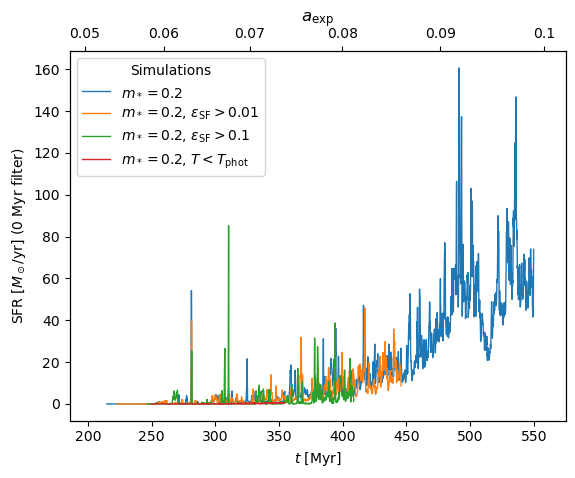

In [78]:
sim_list = [(9, "mstar0p2"), (9, "mstar0p2cut0p01"), (9, "mstar0p2cut0p1"), (9, "mstar0p2cutphot")]
fsigma = 0 * const.Myr

aexp_min = 0.048
aexp_max = 0.102
tick_aexp = np.arange(0.05, 0.1 + 0.01, 0.01)

ax1 = plt.gca()

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    data.SFR = data.starmass_hist1d / np.diff(data.time1d)[0]
    SFR_sm = gaussian_filter(data.SFR, sigma=(fsigma / np.diff(data.time1d)[0]))
    
    cond = (SFR_sm > 0)
    ax1.plot(data.time1d[cond] / const.Myr, SFR_sm[cond] / (const.M_sol / const.yr), lw=1, label=sim_latex)

ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.set_xlabel(r"$t$ [Myr]")
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$] ($%.2g~{\rm Myr}$ filter)" % (fsigma / const.Myr))
ax1.legend(title='Simulations', fontsize=10)
#plt.yscale('log')

ax2 = ax1.twiny()
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)

#ax1.set_xlim(250, 400)
#ax1.set_ylim(-1, 31)
    
# save_fig("SFR-cut-comp-zoom")
    

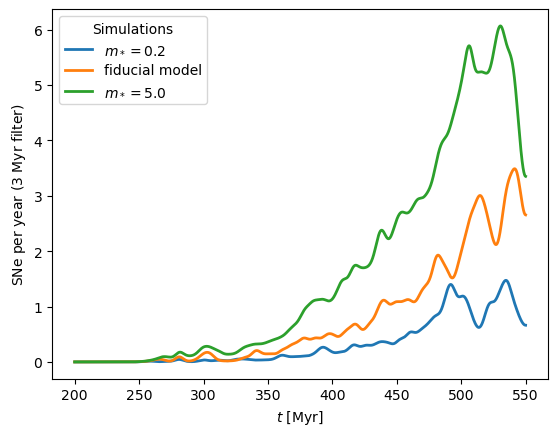

In [6]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]
fsigma = 3 * const.Myr

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    SNeR = data.starnum_hist1d_death / np.diff(data.time1d)[0]
    SNeR_sm = gaussian_filter(SNeR, sigma=(fsigma / np.diff(data.time1d)[0]))
    
    cond = data.time1d > 200 * const.Myr
    plt.plot(data.time1d[cond] / const.Myr, SNeR_sm[cond] * const.yr, lw=2, label=sim_latex)

plt.ylabel(r"SNe per year ($%.2g~{\rm Myr}$ filter)" % (fsigma / const.Myr))
plt.xlabel(r"$t$ [Myr]")
plt.legend(title='Simulations', fontsize=10)
    

(0.01, 71.18803041135693)

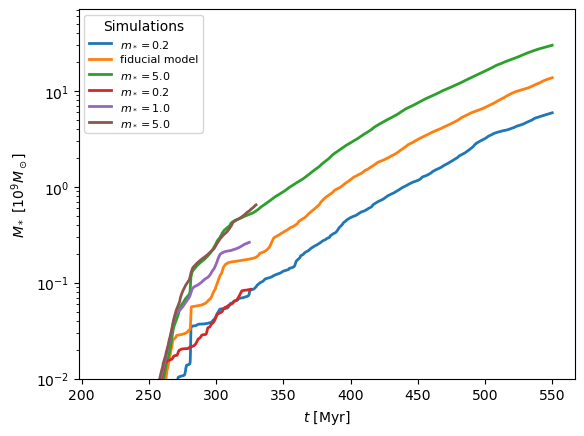

In [206]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0")]

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    starmass = np.cumsum(data.starmass_hist1d)
    
    cond = data.starmass_hist1d > 0
    plt.plot(data.time1d[cond] / const.Myr, starmass[cond] / (1e9 * const.M_sol), label=sim_latex, lw=2)
    
plt.ylabel(r"$M_*$ [$10^9 M_\odot$]")
plt.xlabel(r"$t$ [Myr]")
plt.legend(title='Simulations', fontsize=8)

plt.yscale('log')
#plt.xlim(240, 300)
plt.ylim(1e-2)

#save_fig('starmass-comp')


/tmp/ipykernel_136036/2347092983.py:15: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_ds)
/tmp/ipykernel_136036/2347092983.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=sim_latex)


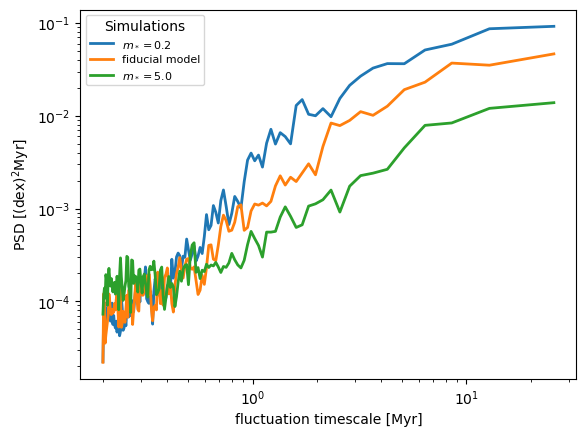

In [214]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]
fac_ds = 1
time_min = 350 * const.Myr
time_max = 550 * const.Myr

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    data.SFR = data.starmass_hist1d / np.diff(data.time1d)[0]  
    time1d_ds, SFR_ds = downsample_hist(data.time1d, data.SFR, fac_ds=fac_ds)

    cond = (time1d_ds > time_min) * (time1d_ds < time_max)
    log_SFR = np.log10(SFR_ds)
    freq, psd = welch(log_SFR[cond], 1/(time1d_ds[1] - time1d_ds[0]), detrend='linear')
    plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=sim_latex)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Simulations', fontsize=8)

# save_fig('psd_comp')


### PDF

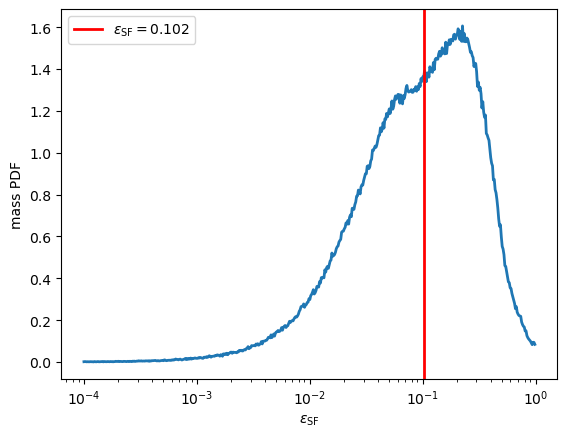

In [215]:
plt.plot(data.eps_sf1d, data.eps_sf_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm SF}$')
plt.ylabel('mass PDF')

eps_sf_median = median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)
plt.axvline(x=eps_sf_median, lw=2, color='red')
add_custleg_to_ax([r'$\varepsilon_{\rm SF} = %.3g$' % eps_sf_median], ['red'])

#plt.axvline(x=0.1, lw=2, color='red')


Text(0, 0.5, 'mass PDF')

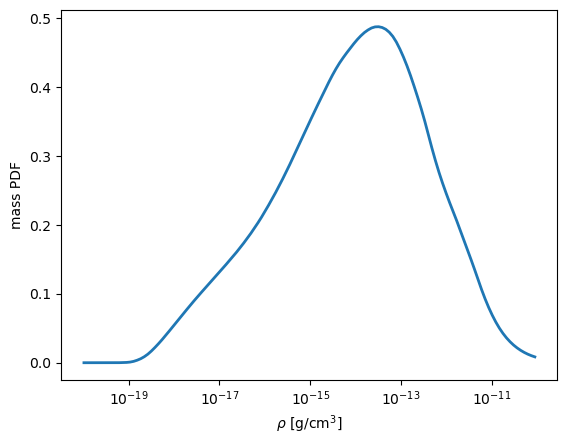

In [216]:
plt.plot(data.density_mff1d, data.density_mff_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('mass PDF')

# eps_sf_median = median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)
# plt.axvline(x=eps_sf_median, lw=2, color='red')
# add_custleg_to_ax([r'$\varepsilon_{\rm SF} = %.3g$' % eps_sf_median], ['red'])


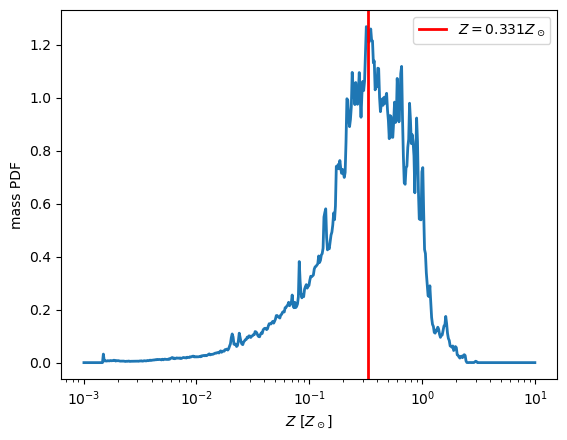

In [51]:
plt.plot(data.metallicity1d / const.Z_sol, data.metallicity_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]')
plt.ylabel('mass PDF')

metallicity_median = median_weighted(data.metallicity1d, data.metallicity_pdf1d)
plt.axvline(x=metallicity_median / const.Z_sol, lw=2, color='red')
add_custleg_to_ax([r'$Z = %.3g Z_\odot$' % (metallicity_median / const.Z_sol)], ['red'])


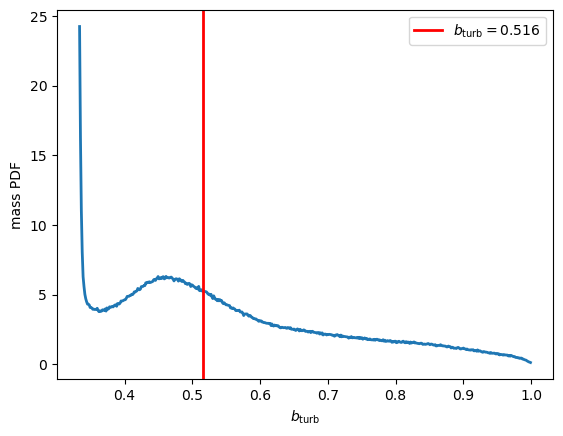

In [20]:
plt.plot(data.b_turb1d, data.b_turb_pdf1d, lw=2)
plt.xlabel(r'$b_{\rm turb}$')
plt.ylabel('mass PDF')

b_turb_median = median_weighted(data.b_turb1d, data.b_turb_pdf1d)
plt.axvline(x=b_turb_median, lw=2, color='red')
add_custleg_to_ax([r'$b_{\rm turb} = %.3g$' % b_turb_median], ['red'])


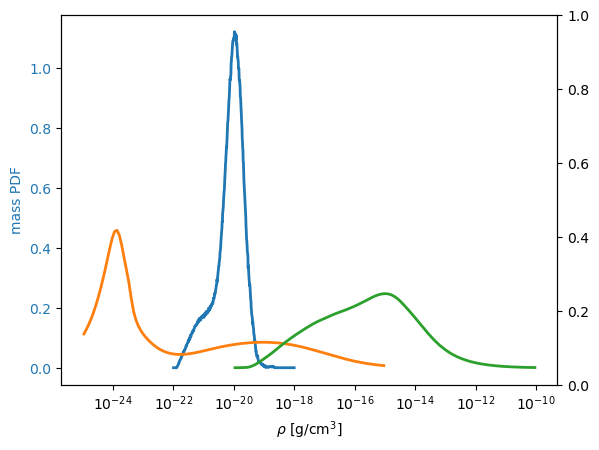

In [197]:
metallicity = 1/3 * const.Z_sol
temp = 10**4
C = 1

ax1 = plt.gca()

ax1.plot(data.density1d, data.density_pdf1d, lw=2)
ax1.plot(data.density_mff1d, data.density_mff_pdf1d, lw=2)
ax1.plot(data.density_mff_trunc1d, data.density_mff_trunc_pdf1d, lw=2)
ax1.set_xscale('log')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel('mass PDF', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()

# n_H = const.X_cosmo * data.density1d / const.m_p
# t_ff = np.sqrt(3 * np.pi / (32 * const.G * data.density1d))
# t_fbk = np.full_like(data.density1d, 0.5 * const.Myr)
# t_cool = 0.87 * const.Myr * (n_H / 10**3.5)**(-1) * (metallicity / const.Z_sol)**(-1) * (temp / 10**4) * np.exp(0.009 * (temp / 10**4)**(-1)) * C**(-1)

# ax2.plot(data.density1d, t_ff / const.Myr, lw=2, color='C3', linestyle='-', label=r'$t_{\rm ff}$')
# ax2.plot(data.density1d, t_fbk / const.Myr, lw=2, color='C3', linestyle='--', label=r'$t_{\rm fbk}$')
# ax2.plot(data.density1d, t_cool / const.Myr, lw=2, color='C3', linestyle='-.', label=r'$t_{\rm cool}$ ($Z=Z_\odot/3$)')

# ax2.set_yscale('log')
# ax2.set_ylabel(r'$t$ [Myr]', color='C3')
# ax2.tick_params(axis='y', labelcolor='C3')
# ax2.legend(title='timescales', fontsize=10)

density_median = median_weighted(data.density1d, data.density_pdf1d)

#save_fig('mff_dens_fastfbk')


Text(0, 0.5, 'mass PDF')

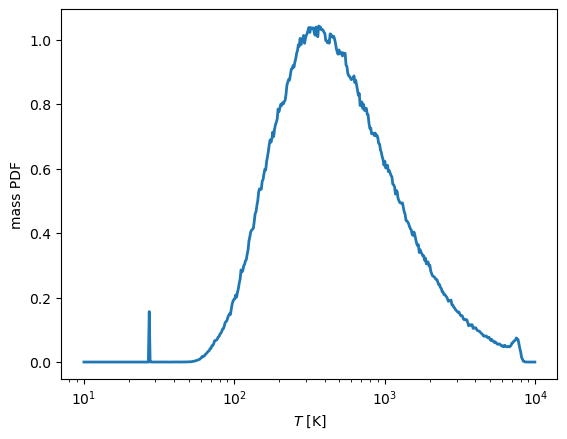

In [193]:
plt.plot(data.temp1d, data.temp_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]')
plt.ylabel('mass PDF')


Text(0, 0.5, 'mass PDF')

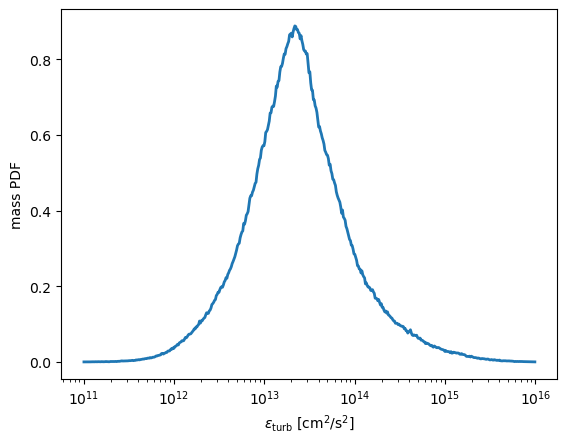

In [194]:
plt.plot(data.energy_turb1d, data.energy_turb_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm turb}$ [${\rm cm^2/s^2}$]')
plt.ylabel('mass PDF')


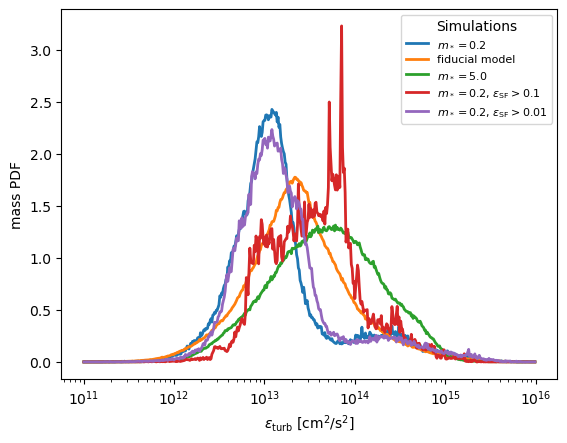

In [110]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (9, "mstar0p2cut0p1"), (9, "mstar0p2cut0p01")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.energy_turb1d, data.energy_turb_pdf1d, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm turb}$ [${\rm cm^2/s^2}$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

# save_fig('eturb-comp2')

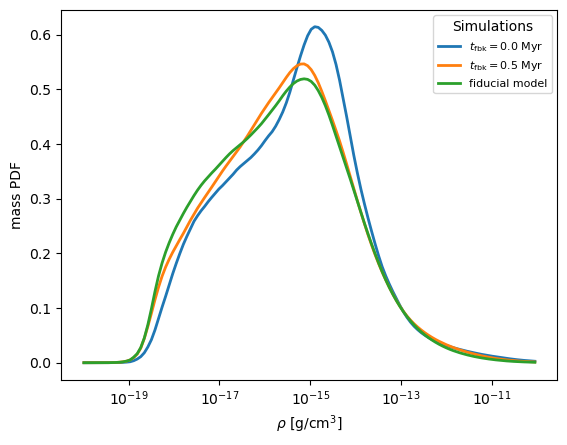

In [112]:
sim_list = [(9, "instantfeedback"), (9, "fastfeedback"), (9, "fiducial")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.density_mff1d, data.density_mff_pdf1d, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('rhomff-comp2')


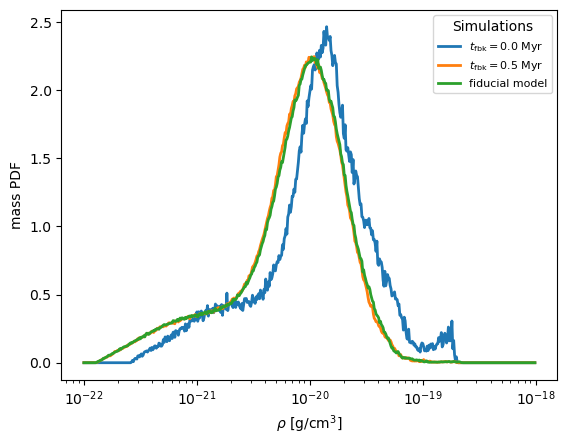

In [77]:
sim_list = [(9, "instantfeedback"), (9, "fastfeedback"), (9, "fiducial")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.density1d, data.density_pdf1d, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('rho-comp')


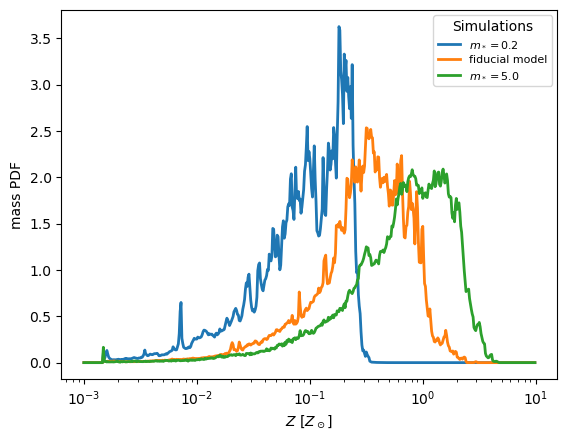

In [31]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.metallicity1d / const.Z_sol, data.metallicity_pdf1d, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('Z-comp')


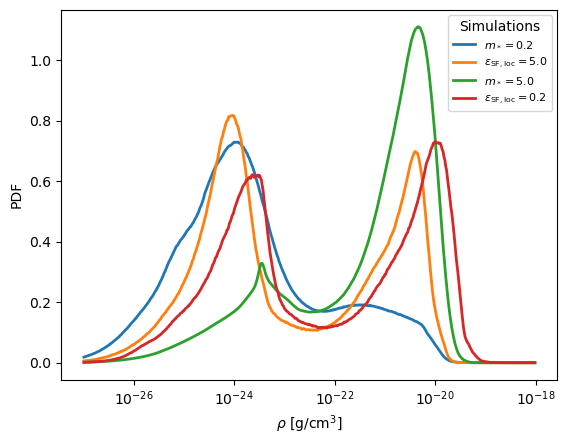

In [49]:
sim_list = [(9, "mstar0p2"), (9, "eps5p0"), (9, "mstar5p0"), (9, "eps0p2")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.density1d_death, data.density_pdf1d_death, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('rhoSNe-comp')


(0.0, 3.0)

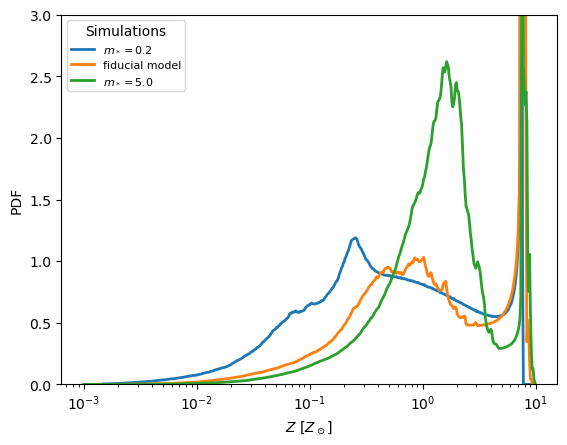

In [34]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.metallicity1d_death / const.Z_sol, data.metallicity_pdf1d_death, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]')
plt.ylabel('PDF')
plt.legend(title='Simulations', fontsize=8)

plt.ylim(0, 3)

#save_fig('Zdeath-comp')


606.338079378776
410.00860239251614
444.57928059732683


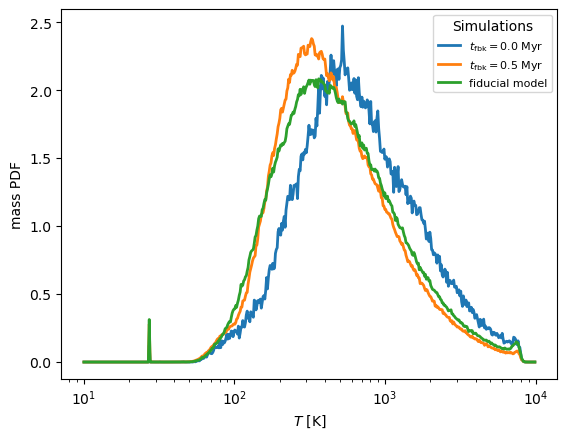

In [78]:
sim_list = [(9, "instantfeedback"), (9, "fastfeedback"), (9, "fiducial")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.temp1d, data.temp_pdf1d, lw=2, label=sim_latex)
    
    print(median_weighted(data.temp1d, data.temp_pdf1d))

plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

# save_fig('temp-comp')


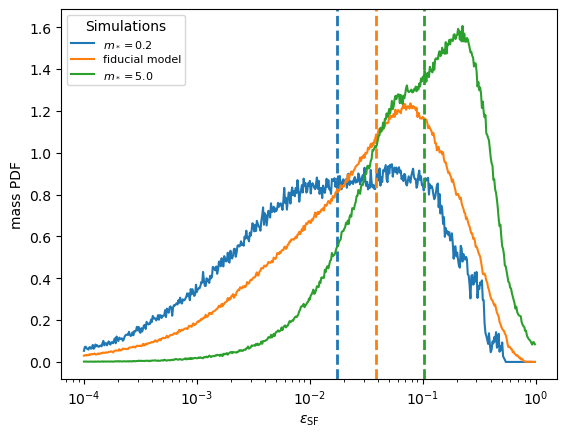

In [90]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    
    eps_sf_loc = 1.
    plt.plot(data.eps_sf1d * eps_sf_loc, data.eps_sf_pdf1d, lw=1.5, label=sim_latex)

    eps_sf_median = median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)
    plt.axvline(x=eps_sf_median, lw=2, color='C%d' % i, linestyle='--')

plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm SF}$')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('epssf-cut-comp-fair')


### phase space

In [57]:
qtile = np.sum(data.eps_sf_pdf1d[data.eps_sf1d < 0.01]) / np.sum(data.eps_sf_pdf1d)
density_cut = qtile_weighted(data.density1d, data.density_pdf1d, qtile)
n_H_cut = const.X_cosmo * density_cut / const.m_H
n_H_cut


1868.5116021898964

Moving to directory '/home/za9132/scratch/romain/round11/mstar0p2'.


Text(0.5, 1.0, '$m_* = 0.2$')

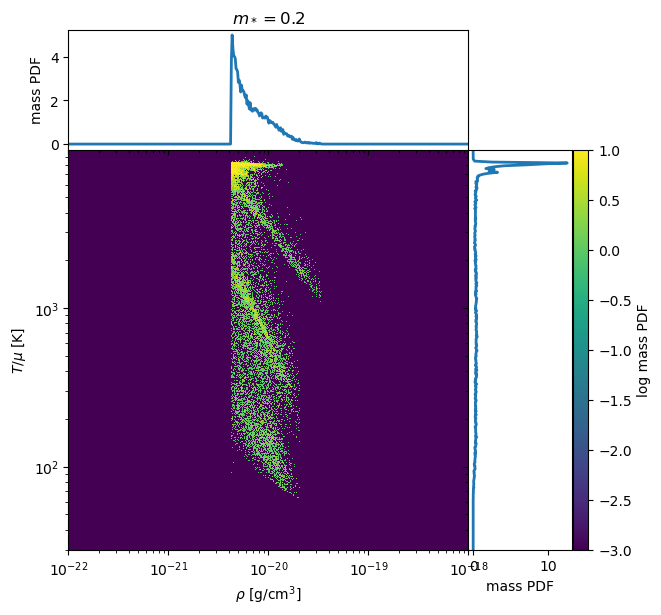

In [26]:
sim_dir = move_to_sim_dir(11, "mstar0p2")
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.density2d, data.temp2d, np.log10(data.density_temp_pdf2d + epsilon).T, vmin=-3, vmax=1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-22, 1e-18)
ax1.set_ylim(30)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.density1d, data.density_pdf1d, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.temp_pdf1d, data.temp1d, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel(r'$T / \mu$ [${\rm K}$]')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')
ax2.set_title(sim_name_to_latex[sim_name])

#density_cut = qtile_weighted(data.density1d, data.density_pdf1d, 0.2)
#ax1.axvline(x=density_cut, color='red')

save_fig('mstar0p2cut')


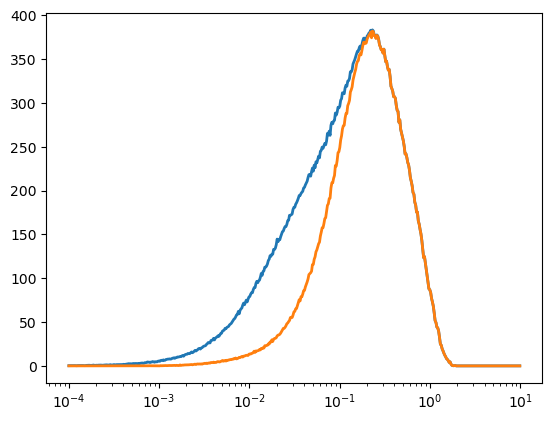

In [41]:
for qtile in [0., 0.25]:
    density_cut = qtile_weighted(data.density1d, data.density_pdf1d, qtile)
    cond = data.density2d > density_cut
    eps_sf_pdf1d_cut = np.sum(data.densityeps_sf_pdf2d * cond[None, :], axis=1)
    plt.plot(data.eps_sf1d, eps_sf_pdf1d_cut, lw=2);

plt.xscale('log')


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
1.9e+03
0.137
Saved figure as 'rhocut-021520241757.png'


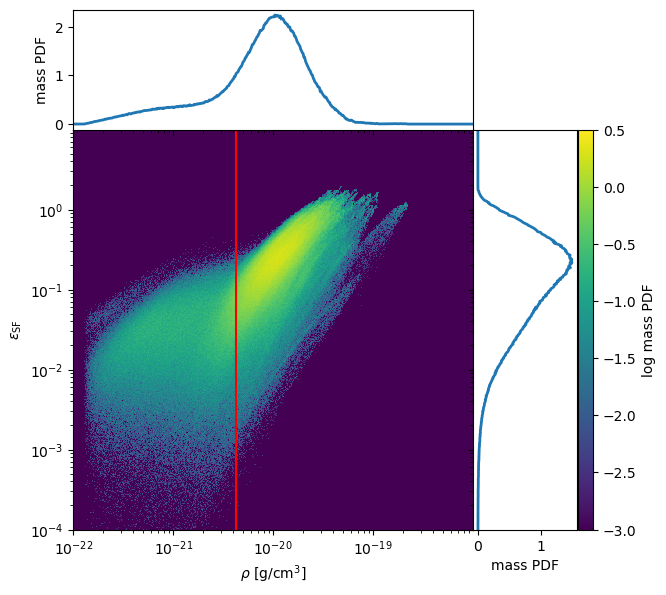

In [167]:
sim_dir = move_to_sim_dir(9, "fiducial")
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.density2d, data.eps_sf2d, np.log10(data.densityeps_sf_pdf2d + epsilon), vmin=-3, vmax=0.5)
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_xlim(1e-22, 1e-18)
#ax1.set_ylim(30)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.density1d, data.density_pdf1d, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.eps_sf_pdf1d, data.eps_sf1d, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel(r'$\varepsilon_{\rm SF}$')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')

density_cut = qtile_weighted(data.density1d, data.density_pdf1d, 0.25)
n_H_cut = density_cut * const.X_cosmo / const.m_H
ax1.axvline(x=density_cut, color='red')
cond = data.density2d > 0
#eps_sf_pdf1d_cut = data.densityeps_sf_pdf2d[:, np.argmin(np.abs(data.density1d - density_cut))]
eps_sf_pdf1d_cut = np.sum(data.densityeps_sf_pdf2d * cond[None, :], axis=1)
eps_sf_cut = median_weighted(data.eps_sf1d, eps_sf_pdf1d_cut)
eps_sf_cut = median_weighted(data.eps_sf1d, eps_sf_pdf1d_cut)

print('%.3g' % n_H_cut)
print('%.3g' % eps_sf_cut)

save_fig('rhocut')


Moving to directory '/home/za9132/scratch/romain/round11/epscut'.
Saved figure as 'epscut-022120241323.png'


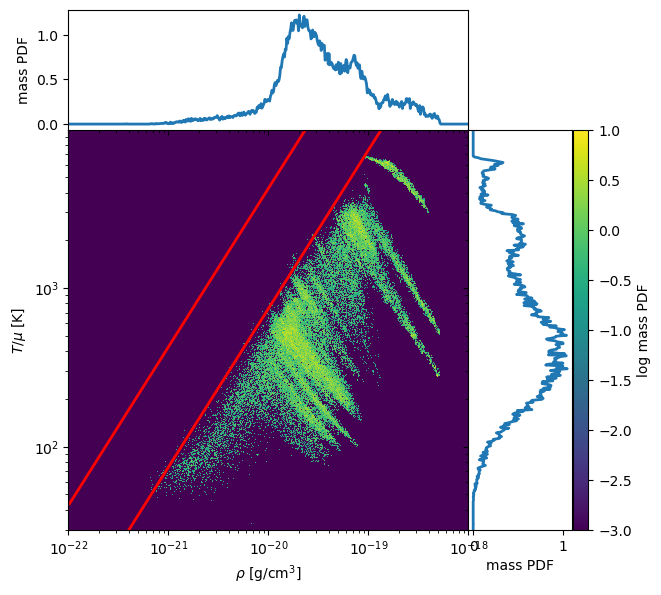

In [33]:
sim_dir = move_to_sim_dir(11, "epscut")
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.density2d, data.temp2d, np.log10(data.density_temp_pdf2d + epsilon).T, vmin=-3, vmax=1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-22, 1e-18)
ax1.set_ylim(30)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.density1d, data.density_pdf1d, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.temp_pdf1d, data.temp1d, lw=2)

temp_cut = broken_powerlaw(data.density2d, 8e3, 2.5e-22, 0, -1, 3)
#ax1.plot(data.density2d, temp_cut, color='red', lw=2)

densitygrid, tempgrid = np.meshgrid(data.density2d, data.temp2d)
dx = 10*const.pc
mach_turb = 10.0
b_turb = 1.0
energy_turb = 3/2 * mach_turb**2 * tempgrid * const.k_B / const.m_p
eps_sf = calc_eps_sf2(densitygrid, energy_turb, tempgrid, dx, b_turb=b_turb)
ax1.contour(densitygrid, tempgrid, eps_sf, levels=[0.01, 0.1], colors='red', linewidths=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel(r'$T / \mu$ [${\rm K}$]')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')
#add_custleg_to_ax(['manual excision', r'$\varepsilon_{\rm SF} < 0.1, \mathcal{M} = 10$'], color_list=['red', 'red'], linestyle_list=['-', '--'], ax=ax1, loc=4)

save_fig('epscut')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.


Text(0.5, 0, 'mass PDF')

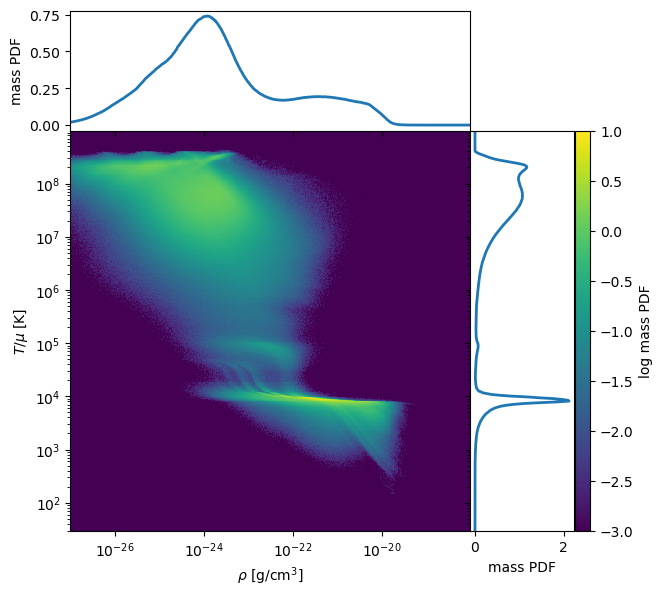

In [86]:
sim_dir = move_to_sim_dir(9, "mstar0p2")
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.density2d_death, data.temp2d_death, np.log10(data.densitytemp_pdf2d_death + epsilon), vmin=-3, vmax=1.0)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(30)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.density1d_death, data.density_pdf1d_death, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.temp_pdf1d_death, data.temp1d_death, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel(r'$T / \mu$ [${\rm K}$]')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')


Moving to directory '/home/za9132/scratch/romain/round11/mstar0p2'.


AttributeError: 'types.SimpleNamespace' object has no attribute 'alpha_virmach_turb_pdf2d'

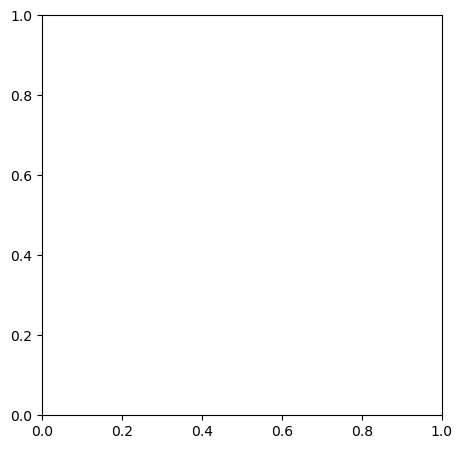

In [7]:
sim_round = 11
sim_name = "mstar0p2"
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.alpha_vir2d, data.mach_turb2d, np.log10(data.alpha_virmach_turb_pdf2d + epsilon), vmin=-3, vmax=1)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.alpha_vir1d, data.alpha_vir_pdf1d, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.mach_turb_pdf1d, data.mach_turb1d, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\alpha_{\rm vir}$')
ax1.set_ylabel(r'$\mathcal{M}_{\rm turb}$')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')
ax1.set_ylim(1e-1, 1e3)
ax2.set_title(sim_name_to_latex[sim_name])

add_custleg_to_ax([r'$\varepsilon_{\rm SF}$'], ['red'], ax=ax1, loc=2)
alpha_vir2d, mach_turb2d = np.meshgrid(data.alpha_vir2d, data.mach_turb2d)
eps_sf = calc_eps_sf(alpha_vir2d, mach_turb2d, b_turb=1.0, eps_sf_loc=1.0)
cs = ax1.contour(alpha_vir2d, mach_turb2d, eps_sf, levels=[1e-2, 1e-1, 1e0], colors='red', linewidths=2)
plt.clabel(cs, [1e-2, 1e-1, 1e0])

#save_fig('phaseplot_alpha_cut')


Moving to directory '/home/za9132/scratch/romain/round11/mstar0p2'.


<a list of 3 text.Text objects>

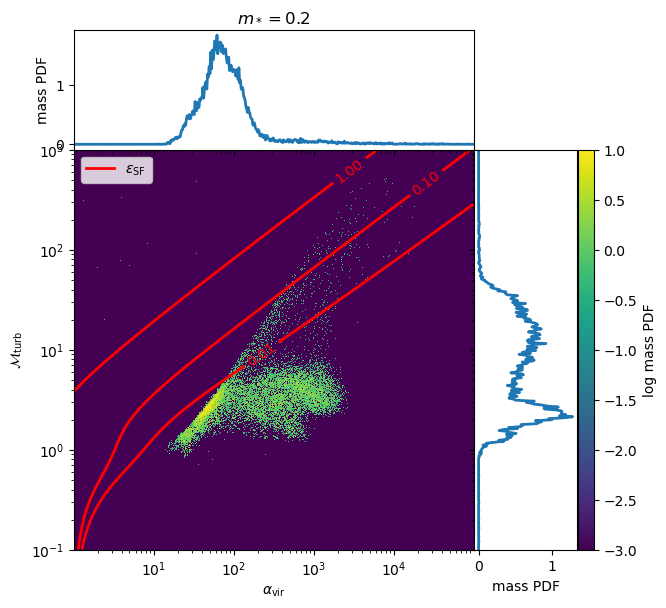

In [20]:
sim_round = 11
sim_name = "mstar0p2"
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.alpha_vir2d, data.mach_turb2d, np.log10(data.alpha_vir_mach_turb_pdf2d + epsilon), vmin=-3, vmax=1)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.alpha_vir1d, data.alpha_vir_pdf1d, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.mach_turb_pdf1d, data.mach_turb1d, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\alpha_{\rm vir}$')
ax1.set_ylabel(r'$\mathcal{M}_{\rm turb}$')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')
ax1.set_ylim(1e-1, 1e3)
ax2.set_title(sim_name_to_latex[sim_name])

add_custleg_to_ax([r'$\varepsilon_{\rm SF}$'], ['red'], ax=ax1, loc=2)
alpha_vir2d, mach_turb2d = np.meshgrid(data.alpha_vir2d, data.mach_turb2d)
eps_sf = calc_eps_sf(alpha_vir2d, mach_turb2d, b_turb=1.0, eps_sf_loc=1.0)
cs = ax1.contour(alpha_vir2d, mach_turb2d, eps_sf, levels=[1e-2, 1e-1, 1e0], colors='red', linewidths=2)
plt.clabel(cs, [1e-2, 1e-1, 1e0])

#save_fig('phaseplot_alpha_cut')


/tmp/ipykernel_3257313/1568006876.py:18: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(alpha_vir, mach_turb, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])


Text(0, 0.5, '$\\mathcal{M}_{\\rm turb}$')

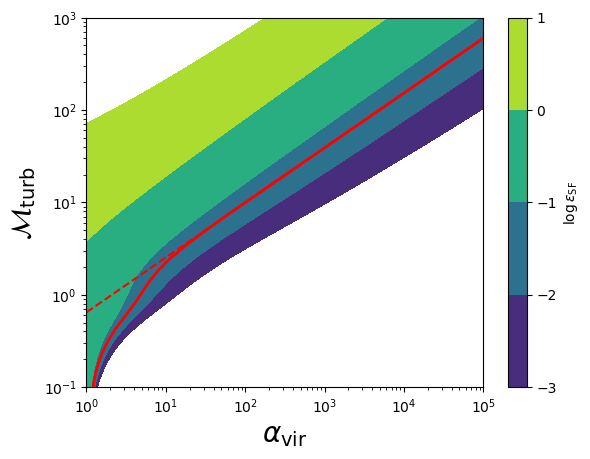

In [30]:
alpha_vir_extrema = (1e0, 1e5)
mach_turb_extrema = (1e-1, 1e3)
num = 512
b_turb = 1.0

alpha_vir_1d = np.logspace(*np.log10(alpha_vir_extrema), num)
mach_turb_1d = np.logspace(*np.log10(mach_turb_extrema), num)
alpha_vir, mach_turb = np.meshgrid(alpha_vir_1d, mach_turb_1d, indexing='ij')
eps_sf = calc_eps_sf(alpha_vir, mach_turb, b_turb=b_turb)

mach_turb_contour = np.zeros_like(alpha_vir_1d)
for i in range(num):
    if (np.max(eps_sf[i, :]) < eps_sf_median) or (np.min(eps_sf[i, :]) > eps_sf_median):
        mach_turb_contour[i] = mach_turb_contour[i-1]
    else:
        mach_turb_contour[i] = mach_turb_1d[np.argmin(np.abs(eps_sf[i, :] - eps_sf_median))]

im = plt.contourf(alpha_vir, mach_turb, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
plt.plot(alpha_vir_1d, mach_turb_contour, lw=2, color='red')
popt, pcov = curve_fit(powerlaw, alpha_vir_1d, mach_turb_contour)
plt.plot(alpha_vir_1d, powerlaw(alpha_vir_1d, *popt), color='red', linestyle='--')

plt.colorbar(im, label=r'$\log \varepsilon_{\rm SF}$')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"$\alpha_{\rm vir}$", fontsize=20)
plt.ylabel(r"$\mathcal{M}_{\rm turb}$", fontsize=20)

# save_fig("SFE-alpha-mach")


In [26]:
popt, pcov = curve_fit(powerlaw, alpha_vir_1d, mach_turb_contour)

mach_turb_contour

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.09430641e-01, 1.19750652e-01, 1.31043906e-01,
       1.43402186e-01, 1.54122813e-01, 1.65644905e-01, 1.74848314e-01,
       1.87919826e-01, 1.98360854e-01, 2.09381996e-01, 2.21015484e-01,
       2.29128060e-01, 2.41858661e-01, 2.50736305e-01, 2.64667483e-01,
       2.74382346e-01, 2.84453801e-01, 2.94894939e-01, 3.05719328e-01,
       3.16941036e-01, 3.28574648e-01, 3.40635281e-01, 3.53138612e-01,
       3.59561343e-01, 3.72759372e-01, 3.86441847e-01, 3.93470283e-01,
       4.07912970e-01, 4.22885790e-01, 4.30577053e-01, 4.46381778e-01,
       4.54500376e-01, 4.71183229e-01, 4.79752904e-01, 4.97362675e-01,
       5.06408490e-01, 5.15618828e-01, 5.34545090e-01, 5.44267163e-01,
       5.64244988e-01, 5.74507231e-01, 5.84956118e-01, 6.06427469e-01,
       6.17456908e-01, 6.40121230e-01, 6.51763476e-01, 6.75687052e-01,
      

In [40]:
from read_ramses import get_halo_cat

halocat = get_halo_cat(54)

In [41]:
halocat.mass

array([4.17384535e-09, 5.71665355e-09, 1.53837019e-09, ...,
       2.28241432e-12, 2.28010210e-12, 2.27910399e-12])